# Solving Blackjack with Q-Learning

<img src="https://raw.githubusercontent.com/till2/Blackjack-Tutorial/main/images/rl_loop.jpg" alt="agent-env diagram" width="500"/>

In this tutorial, we'll explore and solve the _Blackjack-v1_ environment.

__Blackjack__ is one of the most popular casino card games that is also infamous for being beatable under certain conditions.
This version of the game uses an infinite deck (we draw the cards with replacement), so counting cards won't be a viable strategy in our simulated game.


__Objective__: To win, your card sum should be greater than than the dealers without exceeding 21.

__Approach__: To solve this environment by yourself, you can pick your favorite discrete RL algorithm. <br>
The presented solution uses _Q-learning_ (a model-free RL algorithm).

## Imports and Environment Setup

In [1]:
# Author: Till Zemann
# License: MIT License

import gym
import numpy as np
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict

matplotlib.use('TkAgg')
plt.rcParams['text.usetex'] = True
%matplotlib inline

In [2]:
# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make('Blackjack-v1', sab=True)

```py
# Other possible environment configurations:
```
`env = gym.make('Blackjack-v1', natural=True, sab=False)` <br>
`env = gym.make('Blackjack-v1', natural=False, sab=False)`

## Basics: Interacting with the environment

### Observing the environment

First of all, we call `env.reset()` to start an episode. 
This function resets the environment to a starting position and returns an initial `observation`. <br>
We usually also set `done = False`. This variable will be useful later to check if a game is terminated. <br> 
In this tutorial we will use the terms observation and state synonymously but in more complex problems a state might differ from the observation it is based on.

In [3]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

print(observation)

(18, 8, False)


Note that our observation is a 3-tuple consisting of 3 discrete values: 

- The players current sum<br>
- Value of the dealers face-up card <br>
- Boolean whether the player holds a usable ace (An ace is usable if it counts as 11 without busting)

### Executing an action

After receiving our first observation, we are only going to use the `env.step(action)` function to interact with the environment. This function takes an action as input and executes it in the environment. Because that action changes the state of the environment, it returns four useful variables to us. These are:

- `next_state`: This is the observation that the agent will receive after taking the action.
- `reward`: This is the reward that the agent will receive after taking the action.
- `terminated`: This is a boolean variable that indicates whether or not the episode is over.
- `truncated`: This is a boolean variable that also indicates whether the episode ended by early truncation.
- `info`: This is a dictionary that might contain additional information about the environment.

The `next_state`, `reward`, and `done` variables are self-explanatory, but the `info` variable requires some additional explanation. This variable contains a dictionary that might have some extra information about the environment, but in the Blackjack-v1 environment you can ignore it. For example in Atari environments the info dictionary has a `ale.lives` key that tells us how many lives the agent has left. If the agent has 0 lives, then the episode is over.

Blackjack-v1 doesn't have a `env.render()` function to render the environment, but in other environments you can use this function to watch the agent play. Important to note is that using `env.render()` is optional - the environment is going to work even if you don't render it, but it can be helpful to see an episode rendered out to get an idea of how the current policy behaves. Note that it is not a good idea to call this function in your training loop because rendering slows down training by a lot. Rather try to build an extra loop to evaluate and showcase the agent after training.

In [4]:
# sample a random action from all valid actions
action = env.action_space.sample()

# execute the action in our environment and receive the new state, reward and if the episode is done:
observation, reward, terminated, truncated, info = env.step(action)

print('observation:', observation)
print('reward:', reward)
print('terminated:', terminated)
print('truncated:', truncated)
print('info:', info)

observation: (26, 8, False)
reward: -1.0
terminated: True
truncated: False
info: {}


Once `terminated = True` or `truncated=True`, we should stop the current episode and begin a new one with `env.reset()`. <br>
If you continue executing act`ons without resetting the environment, it still responds but the output won't be useful for training (it might even be harmful if the agent learns on invalid data).

## Building an agent

Let's build a `Q-learning agent` to solve _Blackjack-v1_!
We'll need some functions for picking an action and updating the agents action values.
To ensure that the agents expores the environment, one possible solution is the `epsilon-greedy` strategy, where we pick a random action with the percentage `epsilon` and the greedy action (currently valued as the best) `1 - epsilon`. 

In [5]:
class BlackjackAgent():
    
    def __init__(self, lr=1e-3, epsilon=0.1, epsilon_decay=1e-4):
        """
        Initialize an Reinforcement Learning agent with an empty dictionary of state-action values (q_values),
        a learning rate and an epsilon.
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n)) # maps a state to action values
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
    
    def get_action(self, state):
        """
        Returns the best action with probability (1 - epsilon) 
        and a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            action = env.action_space.sample()
            
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            action = np.argmax(self.q_values[state])
        return action
    
    def update(self, state, action, reward, next_state, done):
        """
        Updates the Q-value of an action.
        """
        old_q_value = self.q_values[state][action]
        max_future_q = np.max(self.q_values[next_state])
        target = reward + self.lr * max_future_q * (1 - done)
        self.q_values[state][action] = (1 - self.lr) * old_q_value + self.lr * target
    
    def decay_epsilon(self):
        self.epsilon = self.epsilon - epsilon_decay

To train the agent, we will let the agent play one episode (one complete game is called an episode) at a time and then update it's Q-values after each episode. The agent will have to experience a lot of episodes to explore the environment sufficiently.

Now we should be ready to build the training loop.

In [6]:
# hyperparameters
epsilon = 0.6
n_episodes = 300_000
epsilon_decay = epsilon / n_episodes # less exploration over time

agent = BlackjackAgent(lr=1e-3, epsilon=epsilon)

def train(agent, n_episodes):
    for episode in range(n_episodes):
    
        # reset the environment
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(observation)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated # if the episode terminated or was truncated early, set done to True
            agent.update(state, action, reward, next_state, done)
            state = next_state

        agent.update(state, action, reward, next_state, done)

Great, let's train!

In [7]:
train(agent, n_episodes)

## Visualizing the results

In [8]:
def create_grids(agent, usable_ace=False):
    
    # convert our state-action values to state values 
    # and build a policy dictionary that maps observations to actions
    V = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        V[obs] = np.max(action_values)
        policy[obs] = np.argmax(action_values)
    
    X, Y = np.meshgrid(
        np.arange(12,22), # players count
        np.arange(1,11))  # dealers face-up card
    
    # create the value grid for plotting
    Z = np.apply_along_axis(lambda obs: V[(obs[0], obs[1], usable_ace)], axis=2, arr=np.dstack([X, Y]))
    value_grid = X, Y, Z
    
    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(lambda obs: policy[(obs[0], obs[1], usable_ace)], 
                                      axis=2, arr=np.dstack([X, Y]))
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title='N/A'):
    
    # create a new figure with 2 subplots (left: state values, right: policy)
    X, Y, Z = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1,11), ['A'] + list(range(2,11)))
    ax1.set_title('State values: ' + title);
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel('$V_{\pi}$', fontsize=14, rotation=0)
    ax1.view_init(20, 220)
    
    # plot the policy
    a2x = fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False) # square=True
    ax2.set_title('Policy: ' + title);
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(['A'] + list(range(2,11)), fontsize=12)
    
    # add a legend
    legend_elements = [Patch(facecolor='lightgreen', edgecolor='black', label='Hit'),
                       Patch(facecolor='grey', edgecolor='black', label='Stick')]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

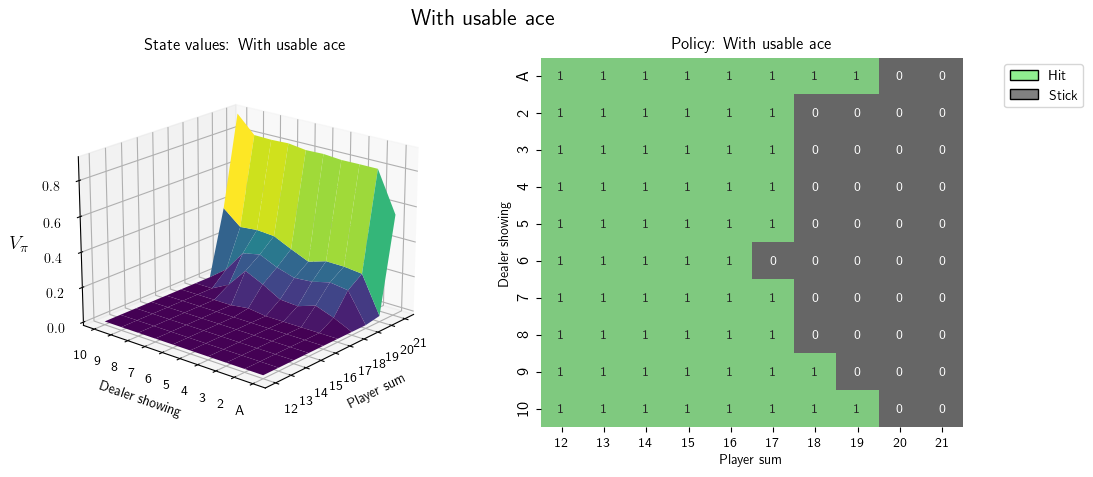

In [9]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title='With usable ace')
plt.show()

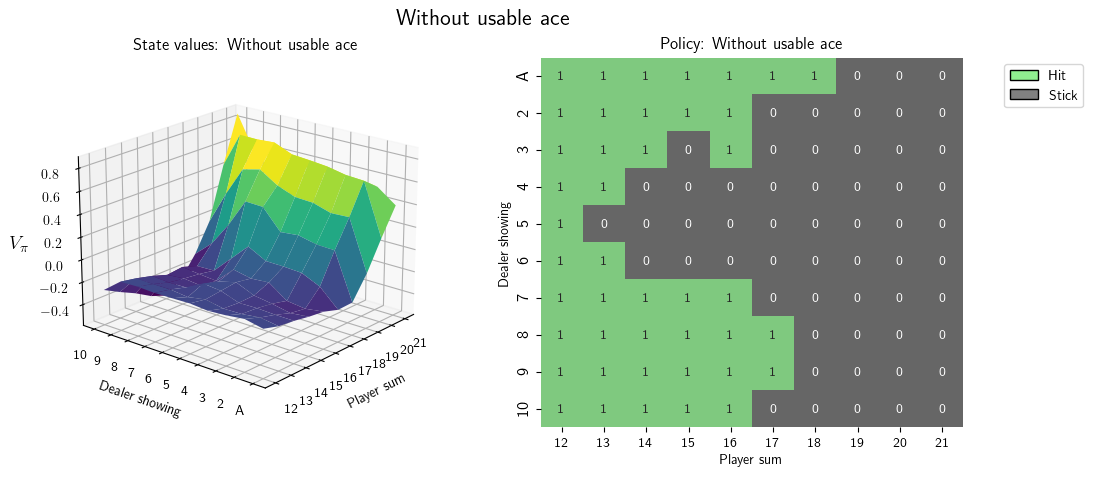

In [10]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title='Without usable ace')
plt.show()

In [11]:
# It's good practice to call env.close() at the end of your script,
# so that any used ressources by the environment will be closed.

env.close()

I hope that this Tutorial helped you get a grip of how to interact with OpenAI-Gym environments and sets you on a journey to solve many more RL challenges.

It is recommended that you solve this environment by yourself (project based learning is really effective!). You can apply your favorite discrete RL algorithm or give Monte Carlo ES a try (covered in [Sutton & Barto](http://incompleteideas.net/book/the-book-2nd.html), section 5.3) - this way you can compare your results directly to the book.

Best of fun!